In [1]:
import cv2
import PIL
import numpy as np
import glob
import os
import micasense.capture as capture
import micasense
from shutil import copyfile
import pandas as pd
import time
import exifread

%matplotlib inline


In [2]:
vuelo="2"
folder="002"
imageDir=r"C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo{}\Multiespectral\{}/".format(vuelo,folder)
outputDir="vuelo_{}/results_{}/".format(vuelo,folder)
temp_folder="temp/"
if not os.path.isdir(outputDir):
    os.makedirs(outputDir)
image_paths=glob.glob(imageDir+"*.tif")
processed_image_paths=glob.glob(outputDir+"*.png")
processed_ids=[processed_image_path.split(os.sep)[1].split("_")[1] for processed_image_path in processed_image_paths ]
unprocessed_ids=[]
valid_image_paths=image_paths.copy()
for image_path in image_paths:
    if image_path[-10:-6] in processed_ids:
        valid_image_paths.remove(image_path)
    else:
        unprocessed_ids.append(image_path[-10:-6])
image_paths=valid_image_paths
print (image_paths)

['C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\002\\IMG_0400_1.tif', 'C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\002\\IMG_0400_2.tif', 'C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\002\\IMG_0400_3.tif', 'C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\002\\IMG_0400_4.tif', 'C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\002\\IMG_0400_5.tif', 'C:\\Users\\EXCELTIC72\\Ingeniería y Economía del Transporte S.A\\Control de Vegetacion - 20201124 - Control de vegetacion\\Vuelo2\\Multiespectral\\0

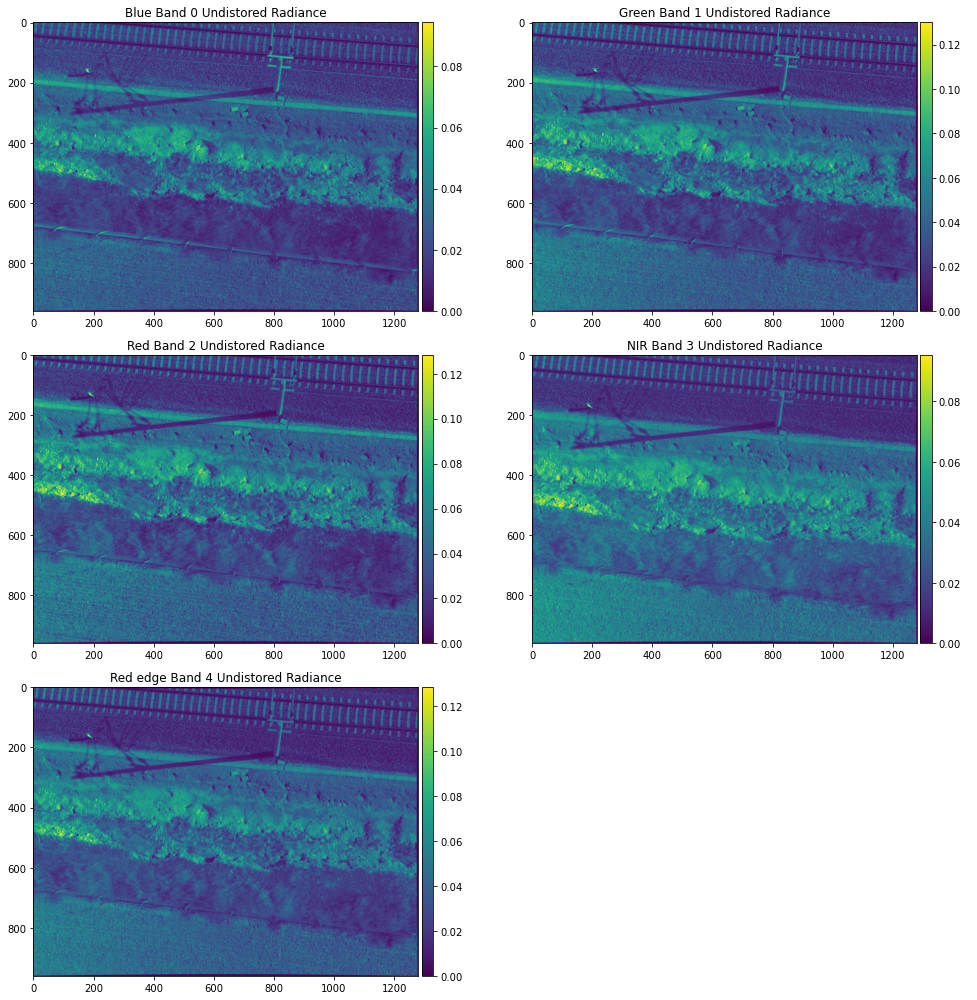

In [3]:
imageNumbers=[imagePath.split("_")[-1] for imagePath in image_paths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(image_paths, imageNumbers)]))
unique_imgs.sort()
imageNames=glob.glob(unique_imgs[30]+"*")
temp_image_names=[]
for imageName in imageNames:
    copyfile(imageName, temp_folder+imageName.split(os.sep)[-1])
    temp_image_names.append(temp_folder+imageName.split(os.sep)[-1])
panelNames = None

if panelNames is not None:
    panelCap = capture.Capture.from_filelist(panelNames)
else:
    panelCap = None

myCapture = capture.Capture.from_filelist(temp_image_names)

for img in myCapture.images:
    if img.rig_relatives is None:
        raise ValueError("Images must have RigRelatives tags set which requires updated firmware and calibration. See the links in text above")

if panelCap is not None:
    if panelCap.panel_albedo() is not None:
        panel_reflectance_by_band = panelCap.panel_albedo()
    else:
        panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order
    panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
    img_type = "reflectance"
    myCapture.plot_undistorted_reflectance(panel_irradiance)
else:
    if False: #capture.dls_present():
        img_type='reflectance'
        myCapture.plot_undistorted_reflectance(capture.dls_irradiance())
    else:
        img_type = "radiance"
        myCapture.plot_undistorted_radiance()    

# Good but not so fast alignment

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

## Alignment settings
match_index = 1 # Index of the band 
max_alignment_iterations = 10
warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment

print("Alinging images. Depending on settings this can take from a few seconds to many minutes")
# Can potentially increase max_iterations for better results, but longer runtimes
warp_matrices, alignment_pairs = imageutils.align_capture(myCapture,
                                                          ref_index = match_index,
                                                          max_iterations = max_alignment_iterations,
                                                          warp_mode = warp_mode,
                                                          pyramid_levels = pyramid_levels)

print("Finished Aligning, warp matrices={}".format(warp_matrices))

Alinging images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished Aligning, warp matrices=[array([[ 1.0148900e+00,  1.1901327e-03, -3.2050514e+01],
       [ 1.1033181e-03,  1.0113877e+00,  2.1983011e-01],
       [ 5.4318170e-06, -4.5622420e-07,  1.0000000e+00]], dtype=float32), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32), array([[ 1.0101396e+00,  2.6705377e-05, -2.2939379e+01],
       [-2.6778626e-04,  1.0121074e+00, -2.9451910e+01],
       [-2.0570699e-06,  1.2028667e-06,  1.0000000e+00]], dtype=float32), array([[ 1.0163876e+00,  5.3210999e-04, -2.6002419e+01],
       [ 1.3049709e-03,  1.0149288e+00,  7.1706285e+00],
       [ 2.9771456e-06,  4.3383682e-07,  1.0000000e+00]], dtype=float32), array([[ 1.0052525e+00,  1.0447915e-03, -2.7002048e+01],
       [-2.5697681e-04,  1.0048883e+00, -4.0132234e-

In [5]:
cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions, match_index, img_type=img_type)

# visualize aligned image

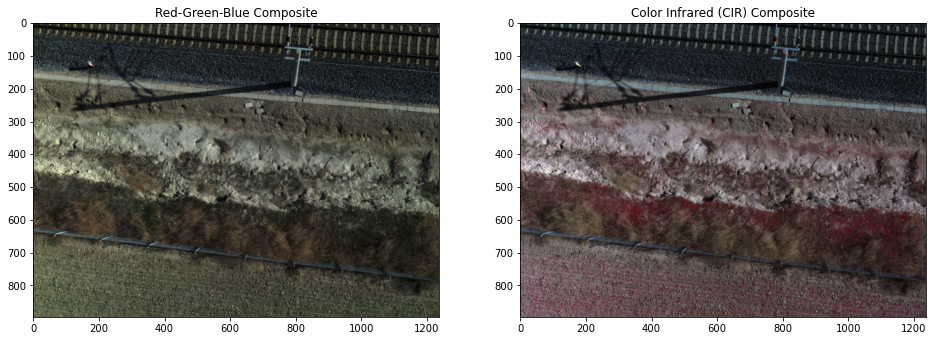

In [6]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

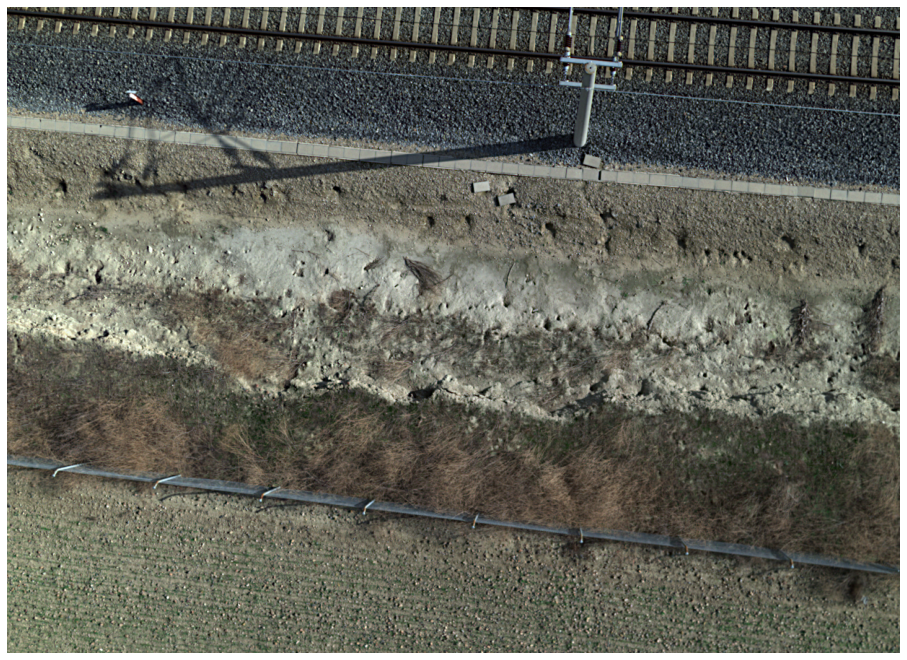

In [7]:
# Create an enhanced version of the RGB render using an unsharp mask
gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
gaussian_rgb[gaussian_rgb<0] = 0
gaussian_rgb[gaussian_rgb>1] = 1
unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
unsharp_rgb[unsharp_rgb<0] = 0
unsharp_rgb[unsharp_rgb>1] = 1

# Apply a gamma correction to make the render appear closer to what our eyes would see
gamma = 1.4
gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
fig = plt.figure(figsize=figsize)
plt.imshow(gamma_corr_rgb, aspect='equal')
plt.axis('off')
plt.show()

# Create NDVI for a batch of images

In [ ]:
imageNumbers=[imagePath.split("_")[-1] for imagePath in image_paths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(image_paths, imageNumbers)]))
unique_imgs.sort()
df=pd.DataFrame()

for j,unique_img in enumerate(unique_imgs):
    imageNames=glob.glob(unique_img+"*")
    temp_image_names=[temp_folder+imageName.split(os.sep)[-1] for imageName in imageNames]
    f = open(imageNames[0], 'rb')
    # Return Exif tags
    tags = exifread.process_file(f)
    row={}
    row["image_path"]=image_path
    for tag in ["GPS GPSLatitude","GPS GPSLongitude"]:
        row[tag]=float(tags[tag].values[0]+tags[tag].values[1]/60+tags[tag].values[2]/3600)
    df=df.append(row,ignore_index=True)
    print("gps data for image {} appended to df".format(imageNames[0]))    
   
    while not os.path.isfile(temp_image_names[-1]):
        print("waiting for the image to download")
        time.sleep(0.5)
    myCapture = capture.Capture.from_filelist(temp_image_names)
        
    cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
    im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions,
                                            match_index, img_type=img_type)
    rgb_band_indices = [2,1,0]
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )
    for i in range(0,im_aligned.shape[2]):
        if img_type == 'reflectance':
            # for reflectance images we maintain white-balance by applying the same display scaling to all bands
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
        elif img_type == 'radiance':
            # for radiance images we do an auto white balance since we don't know the input light spectrum by
            # stretching each display band histogram to it's own min and max
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])
    rgb = im_display[:,:,rgb_band_indices]
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    nir_band = myCapture.band_names_lower().index('nir')
    red_band = myCapture.band_names_lower().index('red')

    np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

    # Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
    ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

    # remove shadowed areas (mask pixels with NIR reflectance < 20%))
    if img_type == 'reflectance':
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
    elif img_type == 'radiance':
        lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 

    min_display_ndvi = 0.2 # further mask soil by removing low-ndvi values
    #min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
    max_display_ndvi = 1  # for many images, 0.5 and 99.5 are good values
    masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)
    #masked_ndvi = np.ma.masked_where(masked_ndvi > max_display_ndvi, ndvi)
    masked_ndvi[masked_ndvi!=0]=(masked_ndvi[masked_ndvi!=0]-min_display_ndvi)/(max_display_ndvi-min_display_ndvi)
 
    cmap = plt.get_cmap('viridis')
    masked_ndvi_rgb=cmap(masked_ndvi)
    masked_ndvi_rgb = np.delete(masked_ndvi_rgb, 3, 2)
    gray_corrected_image= np.zeros(masked_ndvi_rgb.shape)
    for i in range(3):
        gray_corrected_image[:,:,i]= cv2.cvtColor(gamma_corr_rgb,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_over_gray.png',
                np.where(masked_ndvi_rgb!=(0,0,0),masked_ndvi_rgb,gray_corrected_image)[:,:,::-1]*255)
#     cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_only.png',
#                 masked_ndvi_rgb[:,:,::-1]*255)
    print("saving {}. {}/{}".format(outputDir+unique_img.split(os.sep)[-1]+'ndvi_over_gray.png',j+1,len(unique_imgs)))
df.to_csv(outputDir+"coordinates.csv")
for temp_file in glob.glob(temp_folder+"*"):
        os.remove(temp_file)
print("df with gps data saved as csv")

gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0400_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to 

waiting for the image to download
saving vuelo_2/results_002/IMG_0423_ndvi_over_gray.png. 24/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0424_1.tif appended to df
waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0424_ndvi_over_gray.png. 25/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0425_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
saving vuelo

saving vuelo_2/results_002/IMG_0449_ndvi_over_gray.png. 50/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0450_1.tif appended to df
saving vuelo_2/results_002/IMG_0450_ndvi_over_gray.png. 51/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0451_1.tif appended to df
saving vuelo_2/results_002/IMG_0451_ndvi_over_gray.png. 52/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0452_1.tif appended to df
saving vuelo_2/results_002/IMG_0452_ndvi_over_gray.png. 53/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_04

saving vuelo_2/results_002/IMG_0470_ndvi_over_gray.png. 71/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0471_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0471_ndvi_over_gray.png. 72/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0472_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0472_ndvi_over_gray.png. 73/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y

waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0491_ndvi_over_gray.png. 92/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0492_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0492_ndvi_over_gray.png. 93/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Control de vegetacion\Vuelo2\Multiespectral\002\IMG_0493_1.tif appended to df
waiting for the image to download
waiting for the image to download
waiting for the image to download
waiting for the image to download
saving vuelo_2/results_002/IMG_0493_ndvi_over_gray.png. 94/200
gps data for image C:\Users\EXCELTIC72\Ingeniería y Economía del Transporte S.A\Control de Vegetacion - 20201124 - Cont

imageNumbers=[imagePath.split("_")[-1] for imagePath in image_paths]
unique_imgs=list(set([imagePath.replace(imageNumber,"") for imagePath, imageNumber in zip(image_paths, imageNumbers)]))
unique_imgs.sort()
df=pd.DataFrame()

for j,unique_img in enumerate(unique_imgs):
    imageNames=glob.glob(unique_img+"*")
    temp_image_names=[]
    for imageName in imageNames:
        copyfile(imageName, temp_folder+imageName.split(os.sep)[-1])
        temp_image_names.append(temp_folder+imageName.split(os.sep)[-1])
     # Open image file for reading (binary mode)

    f = open(temp_image_names[0], 'rb')
    # Return Exif tags
    tags = exifread.process_file(f)
    row={}
    row["image_path"]=image_path
    for tag in ["GPS GPSLatitude","GPS GPSLongitude"]:
        row[tag]=float(tags[tag].values[0]+tags[tag].values[1]/60+tags[tag].values[2]/3600)
    df=df.append(row,ignore_index=True)
    print("gps data for image {} appended to df".format(imageNames[0]))
    
    myCapture = capture.Capture.from_filelist(temp_image_names)
    cropped_dimensions, edges = imageutils.find_crop_bounds(myCapture, warp_matrices, warp_mode=warp_mode)
    im_aligned = imageutils.aligned_capture(myCapture, warp_matrices, warp_mode, cropped_dimensions,
                                            match_index, img_type=img_type)
    rgb_band_indices = [2,1,0]
    im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],myCapture.num_bands+1), dtype=np.float32 )
    for i in range(0,im_aligned.shape[2]):
        if img_type == 'reflectance':
            # for reflectance images we maintain white-balance by applying the same display scaling to all bands
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
        elif img_type == 'radiance':
            # for radiance images we do an auto white balance since we don't know the input light spectrum by
            # stretching each display band histogram to it's own min and max
            im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])
    rgb = im_display[:,:,rgb_band_indices]
    # Create an enhanced version of the RGB render using an unsharp mask
    gaussian_rgb = cv2.GaussianBlur(rgb, (9,9), 10.0)
    gaussian_rgb[gaussian_rgb<0] = 0
    gaussian_rgb[gaussian_rgb>1] = 1
    unsharp_rgb = cv2.addWeighted(rgb, 1.5, gaussian_rgb, -0.5, 0)
    unsharp_rgb[unsharp_rgb<0] = 0
    unsharp_rgb[unsharp_rgb>1] = 1

    # Apply a gamma correction to make the render appear closer to what our eyes would see
    gamma = 1.4
    gamma_corr_rgb = unsharp_rgb**(1.0/gamma)
    nir_band = myCapture.band_names_lower().index('nir')
    red_band = myCapture.band_names_lower().index('red')

    np.seterr(divide='ignore', invalid='ignore') # ignore divide by zero errors in the index calculation

    # Compute Normalized Difference Vegetation Index (NDVI) from the NIR(3) and RED (2) bands
    ndvi = (im_aligned[:,:,nir_band] - im_aligned[:,:,red_band]) / (im_aligned[:,:,nir_band] + im_aligned[:,:,red_band])

    # remove shadowed areas (mask pixels with NIR reflectance < 20%))
    if img_type == 'reflectance':
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < 0.20, ndvi) 
    elif img_type == 'radiance':
        lower_pct_radiance = np.percentile(im_aligned[:,:,3],  10.0)
        ndvi = np.ma.masked_where(im_aligned[:,:,nir_band] < lower_pct_radiance, ndvi) 

    min_display_ndvi = 0.2 # further mask soil by removing low-ndvi values
    #min_display_ndvi = np.percentile(ndvi.flatten(),  5.0)  # modify with these percentilse to adjust contrast
    max_display_ndvi = 1  # for many images, 0.5 and 99.5 are good values
    masked_ndvi = np.ma.masked_where(ndvi < min_display_ndvi, ndvi)
    #masked_ndvi = np.ma.masked_where(masked_ndvi > max_display_ndvi, ndvi)
    masked_ndvi[masked_ndvi!=0]=(masked_ndvi[masked_ndvi!=0]-min_display_ndvi)/(max_display_ndvi-min_display_ndvi)
 
    cmap = plt.get_cmap('viridis')
    masked_ndvi_rgb=cmap(masked_ndvi)
    masked_ndvi_rgb = np.delete(masked_ndvi_rgb, 3, 2)
    gray_corrected_image= np.zeros(masked_ndvi_rgb.shape)
    for i in range(3):
        gray_corrected_image[:,:,i]= cv2.cvtColor(gamma_corr_rgb,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_over_gray.png',
                np.where(masked_ndvi_rgb!=(0,0,0),masked_ndvi_rgb,gray_corrected_image)[:,:,::-1]*255)
#     cv2.imwrite(outputDir+unique_img.split(os.sep)[-1]+'ndvi_only.png',
#                 masked_ndvi_rgb[:,:,::-1]*255)
    print("saving {}. {}/{}".format(outputDir+unique_img.split(os.sep)[-1]+'ndvi_over_gray.png',j+1,len(unique_imgs)))
df.to_csv(outputDir+"coordinates.csv")
for temp_file in glob.glob(temp_folder+"*"):
        os.remove(temp_file)
print("df with gps data saved as csv")